In [34]:
import numpy as np
import os
import geopandas as gpd
import pandas as pd
from scipy import stats as scipy_stats
import rasterio
import rasterio.features
from rasterio import MemoryFile
from affine import Affine
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import rasterstats
from shapely.geometry import Polygon, shape

# Import libs
import sys
module_path = os.path.abspath(os.path.join('..', 'libs'))
if module_path not in sys.path:
    sys.path.append(module_path)
from s3utils import *

Much of this notebook comes from: https://www.youtube.com/watch?v=VIr-pejky6E

## Bring in raster data

In [35]:
S3R = S3Reader('roof-index')
dsm_path = "/missoula/geospatial/downtown_slope.tif" 
dsm = S3R.get_tif_from_s3_as_rio(dsm_path) 
dsm.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -9999.0,
 'width': 1571,
 'height': 1645,
 'count': 1,
 'crs': CRS.from_epsg(6514),
 'transform': Affine(0.9144000000087544, 0.0, 257075.3304003399,
        0.0, -0.9144000000087544, 301627.6416007468)}

## Define Hyperparameters

In [36]:
slope_threshold = 15
kernel_size = 3
kernel_filter = 1

## Convert slope raster to a map of flat and sloped areas

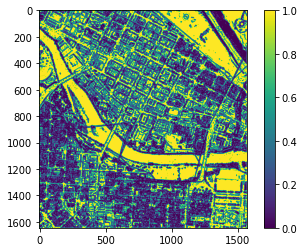

In [37]:
dsm_arr = dsm.read(1)
flat = np.where(dsm_arr > slope_threshold, 0, 1)

plt.imshow(flat.astype(np.uint8))
plt.colorbar()

## Convolve Map with Kernel to Remove Pits

(1645, 1571) (1645, 1571)


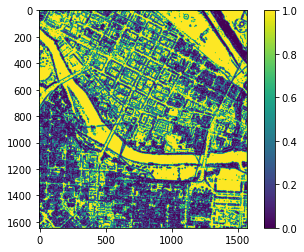

In [38]:
import scipy.signal
kernel = np.ones((kernel_size, kernel_size))

# Use 3x3 kernel of 1 values and then take sum for each patch of image
filled = scipy.signal.convolve2d(flat, kernel, mode='same', boundary='fill', fillvalue=0)
# If at least 2 pixel in a convolution was classified as flat, consider it flat
# Make 2 a parameter here
filled = np.where(filled < kernel_filter, 0, 1)

# Convolve again with same kernel
filled = scipy.signal.convolve2d(filled, kernel, mode='same', boundary='fill', fillvalue=0)
# If all pixels in a given kernel patch aren't flat, classify it as not flat.
filled = np.where(filled != 9, 0, 1)

plt.imshow(filled)
plt.colorbar()
print(flat.shape, filled.shape)

## Create new rasterio object with pits removed

In [39]:
memfile = MemoryFile()
flat = memfile.open(**dsm.profile)
flat.write(filled[np.newaxis].astype(np.float32))

## Convert flat array to vector

In [40]:
out = {}

for idx, item in enumerate(rasterio.features.shapes(flat.read(1), transform=flat.transform)):
    shp, val = item
    out[idx] = {'geometry': shape(shp), 'val': val}
    
flat_vec = gpd.GeoDataFrame(out).T
flat_vec.crs = 'EPSG:6514'
flat_vec

,geometry,val
0,"POLYGON ((257170.428 301626.727, 257170.428 30...",1.0
1,"POLYGON ((257205.175 301626.727, 257205.175 30...",1.0
2,"POLYGON ((257413.658 301626.727, 257413.658 30...",1.0
3,"POLYGON ((257583.737 301626.727, 257583.737 30...",1.0
4,"POLYGON ((257609.340 301626.727, 257609.340 30...",1.0
...,...,...
19999,"POLYGON ((258061.968 300125.282, 258061.968 30...",1.0
20000,"POLYGON ((258239.362 300126.197, 258239.362 30...",1.0
20001,"POLYGON ((258325.315 300125.282, 258325.315 30...",1.0
20002,"POLYGON ((258407.611 300125.282, 258407.611 30...",1.0


## Bring in vector data

In [41]:
bldgs_path = "/missoula/geospatial/downtown_bldgs.zip"
bldgs = S3R.get_shp_from_s3_as_gpd(bldgs_path).to_crs(6514)

## Calculate intersecting area of contiguous flat area and downtown buildings

<AxesSubplot:>

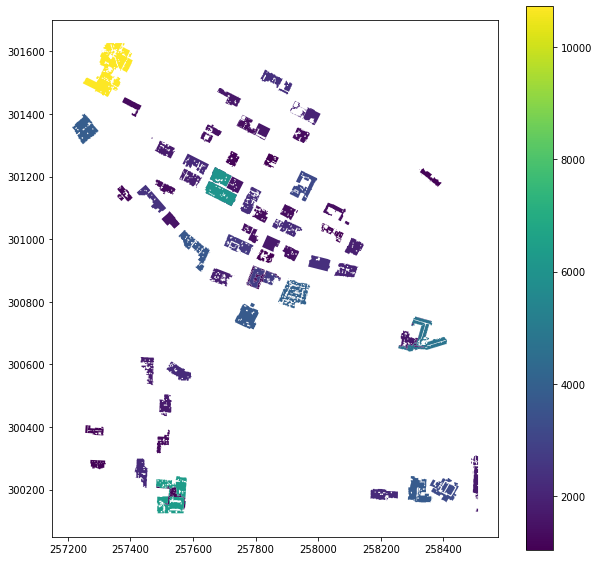

In [43]:
joined = gpd.overlay(flat_vec, bldgs, how='intersection')

joined["area"] = joined['geometry'].area
joined = joined[joined['area'] > 1000]

fig, ax = plt.subplots(1,1, figsize=(10,10))
# show(dsm, ax = ax, title= 'Useable Area (Sq. Ft.)')
joined.plot(column='area', legend=True, ax=ax)

## Write to shapefile